
# Comparison of Manifold Learning methods


An illustration of dimensionality reduction with various manifold learning methods.


Note that the purpose of the MDS is to find a low-dimensional
representation of the data (here 2D) in which the distances respect well
the distances in the original high-dimensional space, unlike other
manifold-learning algorithms, it does not seeks an isotropic
representation of the data in the low-dimensional space.



### Package dependencies

In [4]:
!conda install numba
!conda install annoy
!conda install -c conda-forge umap-learn 
!conda install -c conda-forge keras
!pip install trimap
!pip install rpy2
!pip install networkx
!pip install tensorflow

Solving environment: | ^C
failed

CondaError: KeyboardInterrupt

Solving environment: | ^C
failed

CondaError: KeyboardInterrupt



### Add path to elpigraph package

In [1]:
!git clone https://github.com/j-bac/ElpiGraph.Tensorflow2_eager

Cloning into 'ElpiGraph.Tensorflow2_eager'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 134 (delta 77), reused 114 (delta 61), pack-reused 0
Receiving objects: 100% (134/134), 468.25 KiB | 1.11 MiB/s, done.
Resolving deltas: 100% (77/77), done.


In [2]:
import sys
sys.path.append('ElpiGraph.Tensorflow2_eager/')
sys.path.append('ElpiGraph.Tensorflow2_eager/elpigraph/core_algorithm/')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

import networkx as nx
from elpigraph import *
from PartitionData import PartitionData
from sklearn import manifold, datasets
from sklearn.neighbors import NearestNeighbors
import trimap
from umap import UMAP
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

def knnsearch(A, B, n):
    indices = np.empty((B.shape[0], n),dtype=int)
    distances = np.empty((B.shape[0],B.shape[1], n))

    for i,b in enumerate(B):
        dif = np.sum(np.abs(A - b),axis=1)
#         min_ind = np.argpartition(dif,n)[:n]                        
#         ind = min_ind[np.argsort(dif[min_ind])] 
        ind = np.argsort(dif)[:n]
        indices[i, :] = ind
        distances[i, :] = dif[ind]

    return indices, distances

Using TensorFlow backend.


### Comparison

standard: 0.54 sec
ltsa: 0.78 sec
hessian: 1 sec
modified: 0.87 sec
Isomap: 2 sec
MDS: 9.7 sec
SpectralEmbedding: 0.43 sec
t-SNE: 6.8 sec
UMAP: 8.4 sec
Iteration:  1
Performing PCA on the data
Computing EPG with  60  nodes on  1584  points and  10  dimensions
NODE:
2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 
E= 0.014330389908216322 , MSE= 0.005529952132051675 , EP= 0.008365485481247182 , RP= 0.0004349522949174657
Done
ElPiGraph: 3e+02 sec


/home/utilisateur/.conda/envs/Tensorflow/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


Autoencoder: 16 sec
VAE: 18 sec
TRIMAP: 1.7 sec


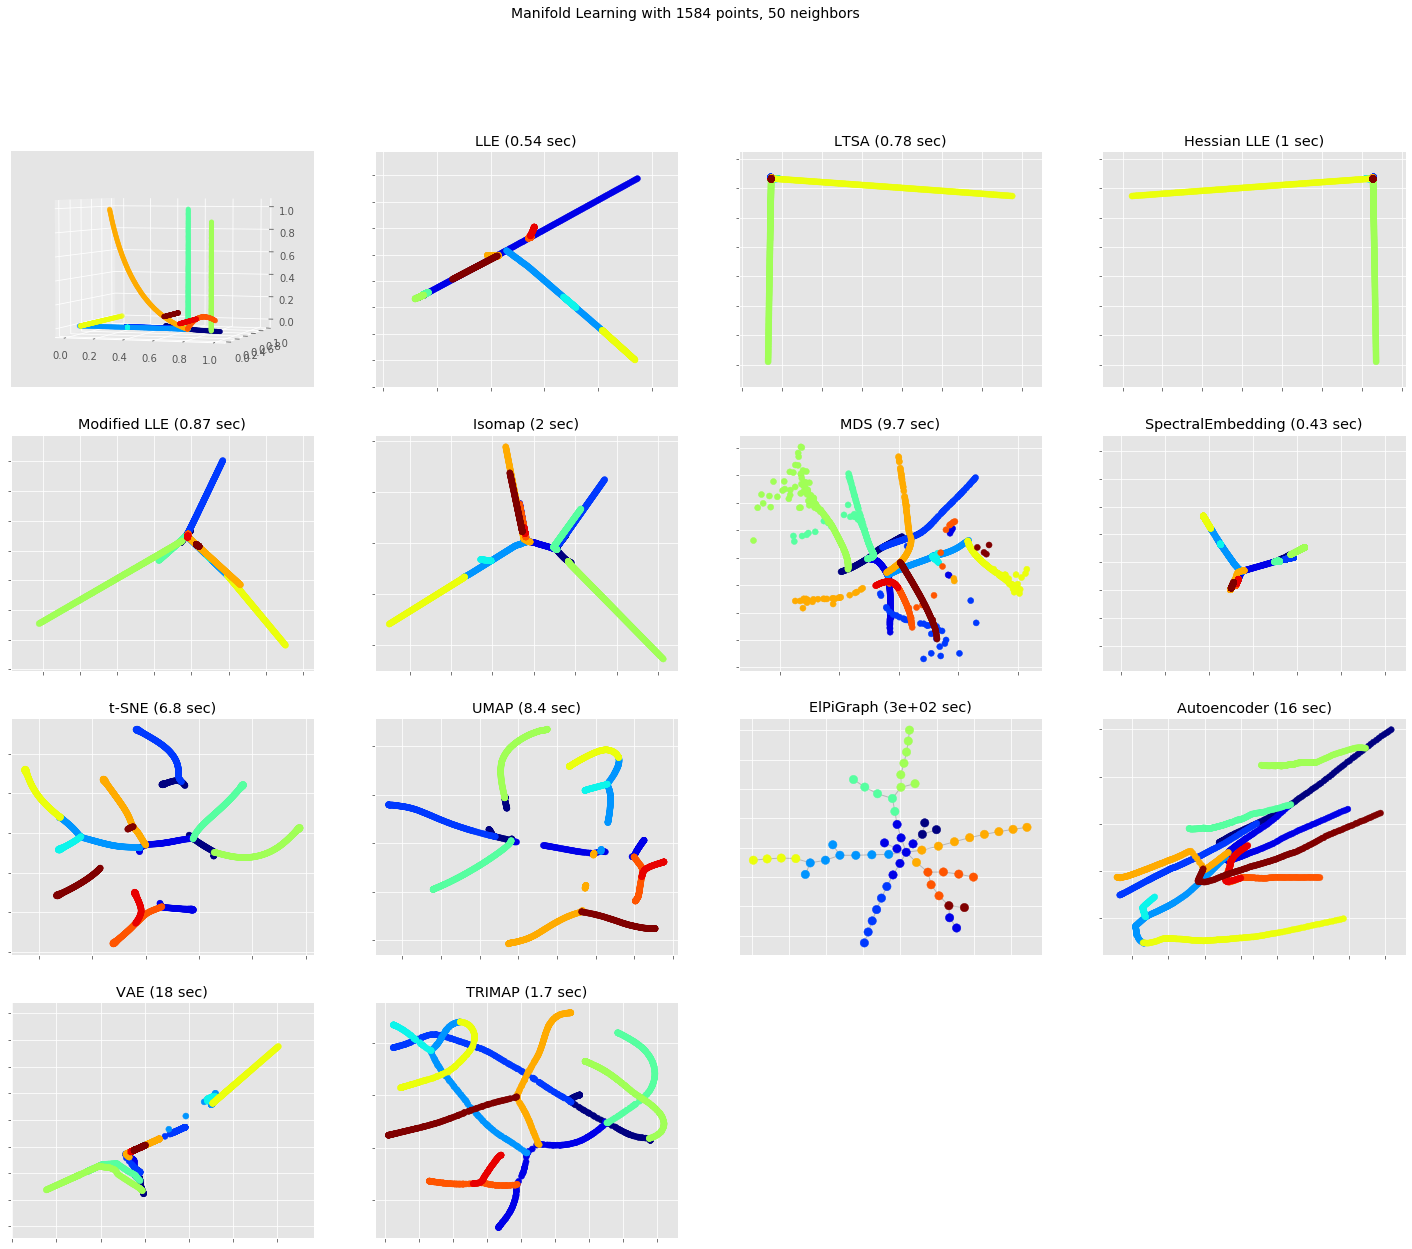

In [4]:
# Next line to silence pyflakes. This import is needed.
Axes3D

X = np.loadtxt('examples/ext10_10_2.txt');
color = np.loadtxt('examples/ext10_10_2.irx').astype('int')
#color = np.full((n_points,),1)
#color[0:49] = 2
#color[50:99] = -1
n_points = X.shape[0]
n_neighbors = 50
n_components = 2
cmap = plt.cm.jet

fig = plt.figure(figsize=(25, 20))
plt.suptitle("Manifold Learning with %i points, %i neighbors"
             % (n_points, n_neighbors), fontsize=14)


ax = fig.add_subplot(441, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=cmap)
ax.view_init(4, -72)

methods = ['standard', 'ltsa', 'hessian', 'modified']
labels = ['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE']

for i, method in enumerate(methods):
    t0 = time()
    Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                        eigen_solver='auto',
                                        method=method).fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (methods[i], t1 - t0))

    ax = fig.add_subplot(4,4,2 + i)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=cmap)
    plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

t0 = time()
Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
t1 = time()
print("Isomap: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(446)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=cmap)
plt.title("Isomap (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
mds = manifold.MDS(n_components, max_iter=100, n_init=1)
Y = mds.fit_transform(X)
t1 = time()
print("MDS: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(447)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=cmap)
plt.title("MDS (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
se = manifold.SpectralEmbedding(n_components=n_components,
                                n_neighbors=n_neighbors)
Y = se.fit_transform(X)
t1 = time()
print("SpectralEmbedding: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(448)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=cmap)
plt.title("SpectralEmbedding (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

t0 = time()
tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
Y = tsne.fit_transform(X)
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(4,4,9)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=cmap)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

t0 = time()
um = UMAP(n_neighbors=n_neighbors,
          n_components=n_components)
Y = um.fit_transform(X)
t1 = time()
print("UMAP: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(4,4,10)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=cmap)
plt.title("UMAP (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


### ElPiGraph ###

nnodes = 12*5


t0 = time()
NodeP, EM, Edges = computeElasticPrincipalTree.computeElasticPrincipalTree(X,nnodes,TrimmingRadius=np.inf)
NodeP, Edges = NodeP.squeeze(), Edges.squeeze()
t1 = time()
print("ElPiGraph: %.2g sec" % (t1 - t0))


#ASSOCIATE EACH NODE WITH KNN DATAPOINTS
Edges2 = Edges
partition, dists = knnsearch(X,NodeP,80)
main_col_nodes = []
for i0,i in enumerate(partition):
    main_col_nodes.append(color[np.argmax(np.bincount(partition[i0]))])


### Draw graph
ax = fig.add_subplot(4,4,11)

g=nx.Graph()
g.add_edges_from(Edges2.T)
pos = nx.kamada_kawai_layout(g,scale=2)
ec = nx.draw_networkx_edges(g, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(g, pos,
                            nodelist=list(np.unique(Edges2)),
                            node_color=main_col_nodes, 
                            node_size=70,
                            cmap=cmap)



plt.title("ElPiGraph (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


### Autoencoder ###

layer_sizes = [64,32,16,8]
#encoder
inputs = Input(shape=(X.shape[1],), name='encoder_input')
x = inputs
for size in layer_sizes:
    x = Dense(size, activation='relu',kernel_initializer='he_uniform')(x)
latent = Dense(n_components,kernel_initializer='he_uniform', name='latent_vector')(x)
encoder = Model(inputs, latent, name='encoder')

#decoder
latent_inputs = Input(shape=(n_components,), name='decoder_input')
x = latent_inputs
for size in layer_sizes[::-1]:
    x = Dense(size, activation='relu',kernel_initializer='he_uniform')(x)
outputs = Dense(X.shape[1] ,activation='sigmoid',kernel_initializer='he_uniform',name='decoder_output')(x)
decoder = Model(latent_inputs, outputs, name='decoder')

#autoencoder
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')

#model summary
# encoder.summary()
# decoder.summary()
# autoencoder.summary()
X_01 = (X-X.min())/(X.max()-X.min())
autoencoder.compile(loss='mse', optimizer='adam')
t0 = time()
autoencoder.fit(x=X_01,y=X_01,epochs=200,verbose=0)
Y = encoder.predict(X)
t1 = time()
print("Autoencoder: %.2g sec" % (t1 - t0))

ax = fig.add_subplot(4,4,12)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=cmap)
plt.title("Autoencoder (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')



### VAE ###

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(n_components,))
    return z_mean + K.exp(z_log_var) * epsilon

layer_sizes = [64,32,16,8]
#encoder
inputs = Input(shape=(X.shape[1],), name='encoder_input')
x = inputs
for size in layer_sizes:
    x = Dense(size, activation='relu',kernel_initializer='he_uniform')(x)
    
z_mean = Dense(n_components,kernel_initializer='he_uniform', name='latent_mean')(x)
z_log_var = Dense(n_components,kernel_initializer='he_uniform', name='latent_sigma')(x)

z = Lambda(sampling, output_shape=(n_components,))([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

#decoder
latent_inputs = Input(shape=(n_components,), name='decoder_input_sampling')
x = latent_inputs
for size in layer_sizes[::-1]:
    x = Dense(size, activation='relu',kernel_initializer='he_uniform')(x)
outputs = Dense(X.shape[1] ,activation='sigmoid',kernel_initializer='he_uniform',name='decoder_output')(x)
decoder = Model(latent_inputs, outputs, name='decoder')

#autoencoder
vae = Model(inputs, decoder(encoder(inputs)[2]), name='vae')


def vae_loss(x, x_decoded_mean):
    xent_loss = K.mean(K.square((x- x_decoded_mean)))
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss
vae.compile(optimizer='adam', loss=vae_loss)


X_01 = (X-X.min())/(X.max()-X.min())
t0 = time()
vae.fit(x=X_01,y=X_01,epochs=200,verbose=0)
Y = encoder.predict(X)[0]
t1 = time()
print("VAE: %.2g sec" % (t1 - t0))

ax = fig.add_subplot(4,4,13)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=cmap)
plt.title("VAE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')



### TRIMAP ###

t0 = time()
Y = trimap.TRIMAP(verbose=False).fit_transform(X)
t1 = time()
print("TRIMAP: %.2g sec" % (t1 - t0))

ax = fig.add_subplot(4,4,14)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=cmap)
plt.title("TRIMAP (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


plt.show()

No execution time. Bigger title. Remove VAE,HLLE,LSTA. Add PCA. Implement data generation.
ElPiGraph represented as a tree + data points with random angle. Add Fruchterman-reingold after kamada-kawai


### Testing ElPiGraph

#### R version

In [16]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [19]:
%%R
library(ElPiGraph.R)
library(igraph)

nnodesR <- 12*20
data <- read.table('examples/ext10_10_2.txt',header=FALSE,sep="\t")
data <- as.matrix(data)
TreeEPG <- computeElasticPrincipalTree(X = data, NumNodes = nnodesR,
                                       n.cores = 1,
                                       TrimmingRadius=Inf,
                                       drawAccuracyComplexity = FALSE, 
                                       drawEnergy = FALSE,
                                       verbose = FALSE,
                                       drawPCAView = FALSE)

NodePR <- TreeEPG[[1]]$NodePositions
EdgesR <- TreeEPG[[1]]$Edges$Edges

[1] "Generating the initial configuration"
[1] "Creating a chain in the 1st PC with 2 nodes"
[1] "Constructing tree 1 of 1 / Subset 1 of 1"
[1] "Performing PCA on the data"
[1] "Using standard PCA"
[1] "10 dimensions are being used"
[1] "100% of the original variance has been retained"
[1] "The elastic matrix is being used. Edge configuration will be ignored"
[1] "Computing EPG with 240 nodes on 1584 points and 10 dimensions"
[1] "Using a single core"
Nodes = 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 16

In [20]:
%R -o NodePR -o EdgesR -o nnodesR
NodeP = np.array(NodePR)
Edges = np.array(EdgesR).T-1
nnodes = int(nnodesR[0])

#### Python version

In [ ]:
nnodes = 36
NodeP, EM, Edges = computeElasticPrincipalTree.computeElasticPrincipalTree(X,nnodes,TrimmingRadius=np.inf)
NodeP, Edges = NodeP.squeeze(), Edges.squeeze()

### Graph viz

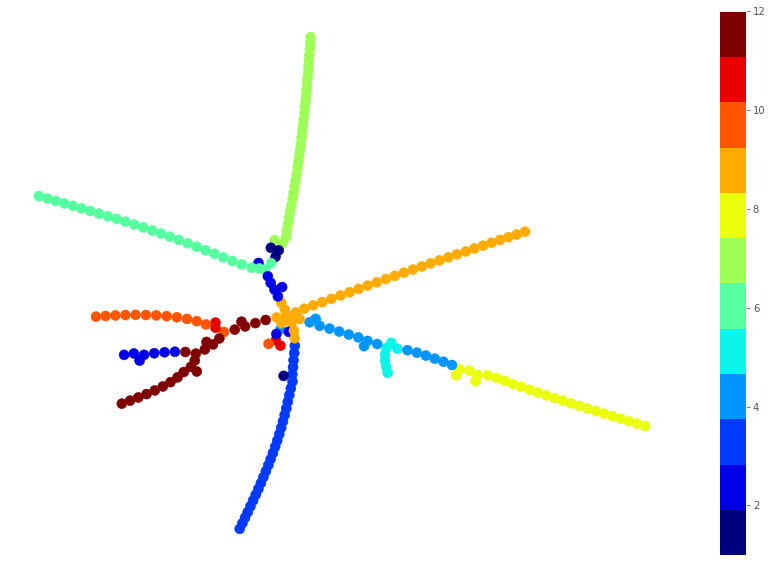

In [201]:
plt.figure(figsize=(15,10))

#optional knn tree/MST display for comparison
# nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)
# distances, indices = nbrs.kneighbors(X)
# g=nx.Graph()
# g.add_edges_from(indices)
# pos = nx.kamada_kawai_layout(g,scale=2)
# ec = nx.draw_networkx_edges(g, pos, alpha=0.2)
# nc = nx.draw_networkx_nodes(g, pos,
#                             nodelist=list(np.unique(indices)),
#                             node_color=color, 
#                             node_size=100,
#                             cmap=plt.cm.jet)
# T=nx.minimum_spanning_tree(g)

#ASSOCIATE EACH DATAPOINT WITH ONE NODE
# partition, dists = PartitionData(X,NodeP,MaxBlockSize=10**6, SquaredX=(X**2).sum(axis=1).reshape((X.shape[0], 1)))
# #remove nodes with no associated datapoint
# empty_nodes = list(set(range(nnodes))-set(np.unique(partition)))
# Edges2=Edges
# ind_to_del = []
# for i in range(Edges.shape[1]):
#     if (Edges2[0,i] in empty_nodes) or (Edges2[1,i] in empty_nodes):
#         ind_to_del.append(i)
# Edges2 = np.delete(Edges,ind_to_del,axis=1)
# #associate color(s) to nodes
# pie_col_nodes = []
# main_col_nodes = []
# for i0,i in enumerate(np.unique(partition)):
#     pie_col_nodes.append(color[np.where(partition.squeeze()==i)[0]])
#     main_col_nodes.append(np.argmax(np.bincount(pie_col_nodes[i0])))
    
#OR ASSOCIATE EACH NODE WITH KNN DATAPOINTS
Edges2 = Edges
partition, dists = knnsearch(X,NodeP,20)
pie_col_nodes = []
main_col_nodes = []
for i0,i in enumerate(partition):
    pie_col_nodes.append(color[partition[i0]])
    main_col_nodes.append(np.argmax(np.bincount(color[partition[i0]])))

### Draw graph
g=nx.Graph()
g.add_edges_from(Edges2.T)
pos = nx.kamada_kawai_layout(g,scale=2)
ec = nx.draw_networkx_edges(g, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(g, pos,
                            nodelist=list(np.unique(Edges2)), #list(np.unique(partition)) if using PartitionData
                            node_color=main_col_nodes, 
                            node_size=100,
                            cmap=discrete_cmap(12,cmap))


plt.colorbar(nc)
plt.axis('off')
plt.show()

In [197]:
np.argmax(np.bincount(partition[0]))

1080

/home/utilisateur/.conda/envs/Tensorflow/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


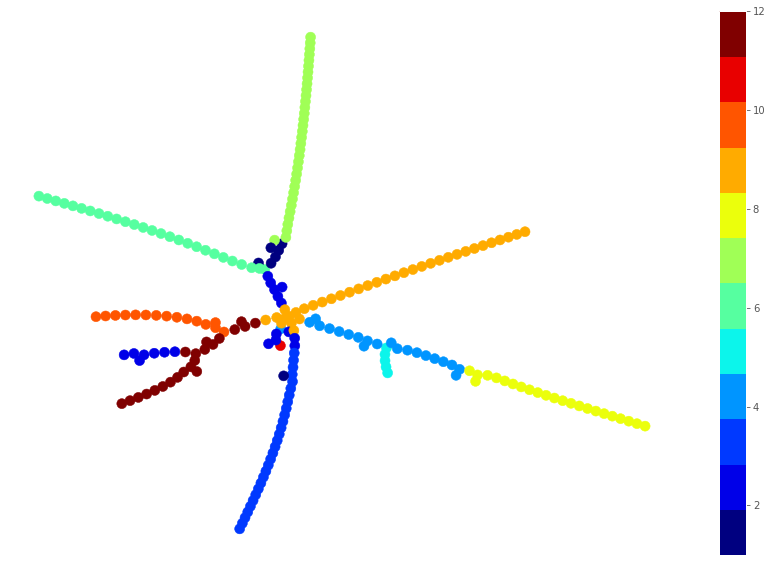

In [192]:
plt.figure(figsize=(15,10))
#OR ASSOCIATE EACH NODE WITH KNN DATAPOINTS
Edges2 = Edges
partition, dists = knnsearch(X,NodeP,10)
main_col_nodes = []
for i0,i in enumerate(partition):
    main_col_nodes.append(color[np.argmax(np.bincount(partition[i0]))])


### Draw graph
g=nx.Graph()
g.add_edges_from(Edges2.T)
pos = nx.kamada_kawai_layout(g,scale=2)
ec = nx.draw_networkx_edges(g, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(g, pos,
                            nodelist=list(np.unique(Edges2)), #list(np.unique(partition)) if using PartitionData
                            node_color=main_col_nodes, 
                            node_size=100,
                            cmap=discrete_cmap(12,cmap))


plt.colorbar(nc)
plt.axis('off')
plt.show()

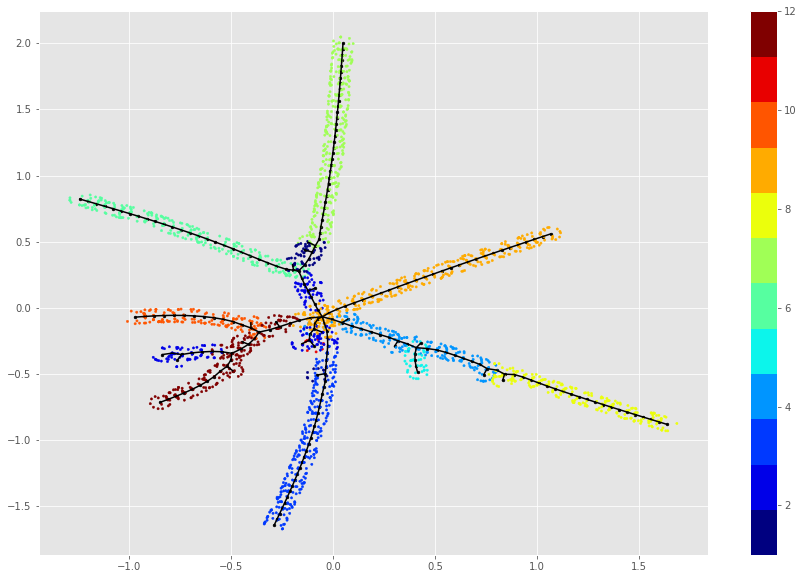

In [193]:
plt.figure(figsize=(15,10))
# Scatter nodes
idx=np.array([pos[i] for i in range(len(pos))])
plt.scatter(idx[:,0],idx[:,1],s=8,c='black')

#Plot datapoints in circle around nodes
for i in range(len(partition)):
    # radius of the circle
    r = .05
    # random angle
    alpha = 2 * np.pi * np.random.random(size=partition.shape[1])
    # calculating coordinates
    x = r * np.cos(alpha) + idx[i,0]
    y = r * np.sin(alpha) + idx[i,1]
    
    #plt.scatter(x,y,c=[main_col_nodes[i]]*len(x),s=5,cmap=discrete_cmap(12,cmap))
    plt.scatter(x,y,c=pie_,s=5,cmap=discrete_cmap(12,cmap))

    plt.clim(1,12)
plt.colorbar()
#Plot edges
for i in range(Edges.shape[1]):
    x_coo = np.concatenate((idx[Edges2[0,i],[0]],idx[Edges2[1,i],[0]]))
    y_coo = np.concatenate((idx[Edges2[0,i],[1]],idx[Edges2[1,i],[1]]))
    plt.plot(x_coo,y_coo,c='black')